# EOPF Dataset Zarr manipulation

In [90]:
import os
import glob
import natsort
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

## Import dataset path

In [91]:
version = "V4"
TRAIN_DIR = f"/mnt/disk/dataset/sentinel-ai-processor/{version}/train/input"
VAL_DIR = f"/mnt/disk/dataset/sentinel-ai-processor/{version}/val/input"
TEST_DIR = f"/mnt/disk/dataset/sentinel-ai-processor/{version}/test/input"

In [92]:
# List zarr fil in a given directory
zarr_path = natsort.natsorted(glob.glob(os.path.join(TRAIN_DIR, "*.zarr"), recursive=False))

In [ ]:
# Open a zarr product
dt = xr.open_datatree(zarr_path[11], engine="zarr", mask_and_scale=False, chunks={})
ds = dt.measurements.reflectance.r10m

## Plot data chunks

In [15]:
def get_chunk_info(data_tree, band, res):
    """
    Extract chunk size and number of chunks from a dataset.

    Parameters:
    - data_tree: xarray.DataTree
    - band: str, e.g. "b03"
    - resolution: str, y-dimension name (e.g. "y_10m")
    - x_res: str, x-dimension name (e.g. "x_10m")

    Returns:
    - chunk_size_y: int
    - chunk_size_x: int
    - nb_chunks_y: int
    - nb_chunks_x: int
    """
    res_key = f"r{res}"
    y_res = f"y_{res}"
    x_res = f"x_{res}"
    data_tree = data_tree.measurements.reflectance[res_key]

    chunk_size_y = data_tree[band].chunksizes[y_res][0]
    chunk_size_x = data_tree[band].chunksizes[x_res][0]
    nb_chunks_y = len(data_tree[band].chunksizes[y_res])
    nb_chunks_x = len(data_tree[band].chunksizes[x_res])

    print(f"Chunk size: y={chunk_size_y}, x={chunk_size_x}")
    print(f"Number of chunks: y={nb_chunks_y}, x={nb_chunks_x}")

    return chunk_size_y, chunk_size_x, nb_chunks_y, nb_chunks_x

In [16]:
def get_chunk(data_tree, res, chunk_y_idx, chunk_x_idx, chunk_size_y, chunk_size_x):
    """
    Extract a specific chunk from a given band at a given spatial resolution in a DataTree.

    Parameters:
    - data_tree: xarray.DataTree
        The root DataTree object loaded from a Zarr store (e.g., xr.open_datatree(...)).
    - band: str
        The band name to extract (e.g., "b03").
    - res: str
        The spatial resolution as a string (e.g., "10m", "20m", "60m").
    - chunk_y_idx: int
        Index of the chunk along the vertical (y) axis.
    - chunk_x_idx: int
        Index of the chunk along the horizontal (x) axis.

    Returns:
    - xarray.DataArray
        A DataArray corresponding to the specified chunk.
    """
    res_key = f"r{res}"
    y_res = f"y_{res}"
    x_res = f"x_{res}"
    data = data_tree.measurements.reflectance[res_key]

    y_start = chunk_y_idx * chunk_size_y
    x_start = chunk_x_idx * chunk_size_x
    return data.isel(
        {y_res: slice(y_start, y_start + chunk_size_y),
         x_res: slice(x_start, x_start + chunk_size_x)}
    )

In [17]:
def plot_all_chunks(data_tree, band, res, chunk_size_y, chunk_size_x, nb_chunks_y, nb_chunks_x, cmap="viridis", verbose= True, figsize_scale=3):
    """
    Plot all chunks of a given band and resolution.

    Parameters:
    - data_tree: xarray Dataset (e.g. dt.measurements.reflectance.r20m)
    - band: str, band name (e.g. "b05")
    - cmap: str, matplotlib colormap
    - figsize_scale: int, scales the figure size (default is 3)
    """
    res_key = f"r{res}"
    y_res = f"y_{res}"
    x_res = f"x_{res}"
    data_tree = dt.measurements.reflectance[res_key]
    # Set up plot grid
    fig, axes = plt.subplots(
        nb_chunks_y, nb_chunks_x,
        figsize=(figsize_scale * nb_chunks_x, figsize_scale * nb_chunks_y)
    )

    # Plot each chunk
    for i in range(nb_chunks_y):
        for j in range(nb_chunks_x):
            ax = axes[i, j] if nb_chunks_y > 1 else axes[j]
            y_start = i * chunk_size_y
            x_start = j * chunk_size_x
            chunk = data_tree[band].isel(
                {y_res: slice(y_start, y_start + chunk_size_y),
                 x_res: slice(x_start, x_start + chunk_size_x)}
            ).load()
            ax.imshow(chunk, cmap=cmap, vmin=0, vmax=1)
            ax.set_title(f"Chunk ({i},{j})")
            ax.axis("off")
    if verbose:
        plt.tight_layout()
        plt.show()

Chunk size: y=305, x=305
Number of chunks: y=6, x=6


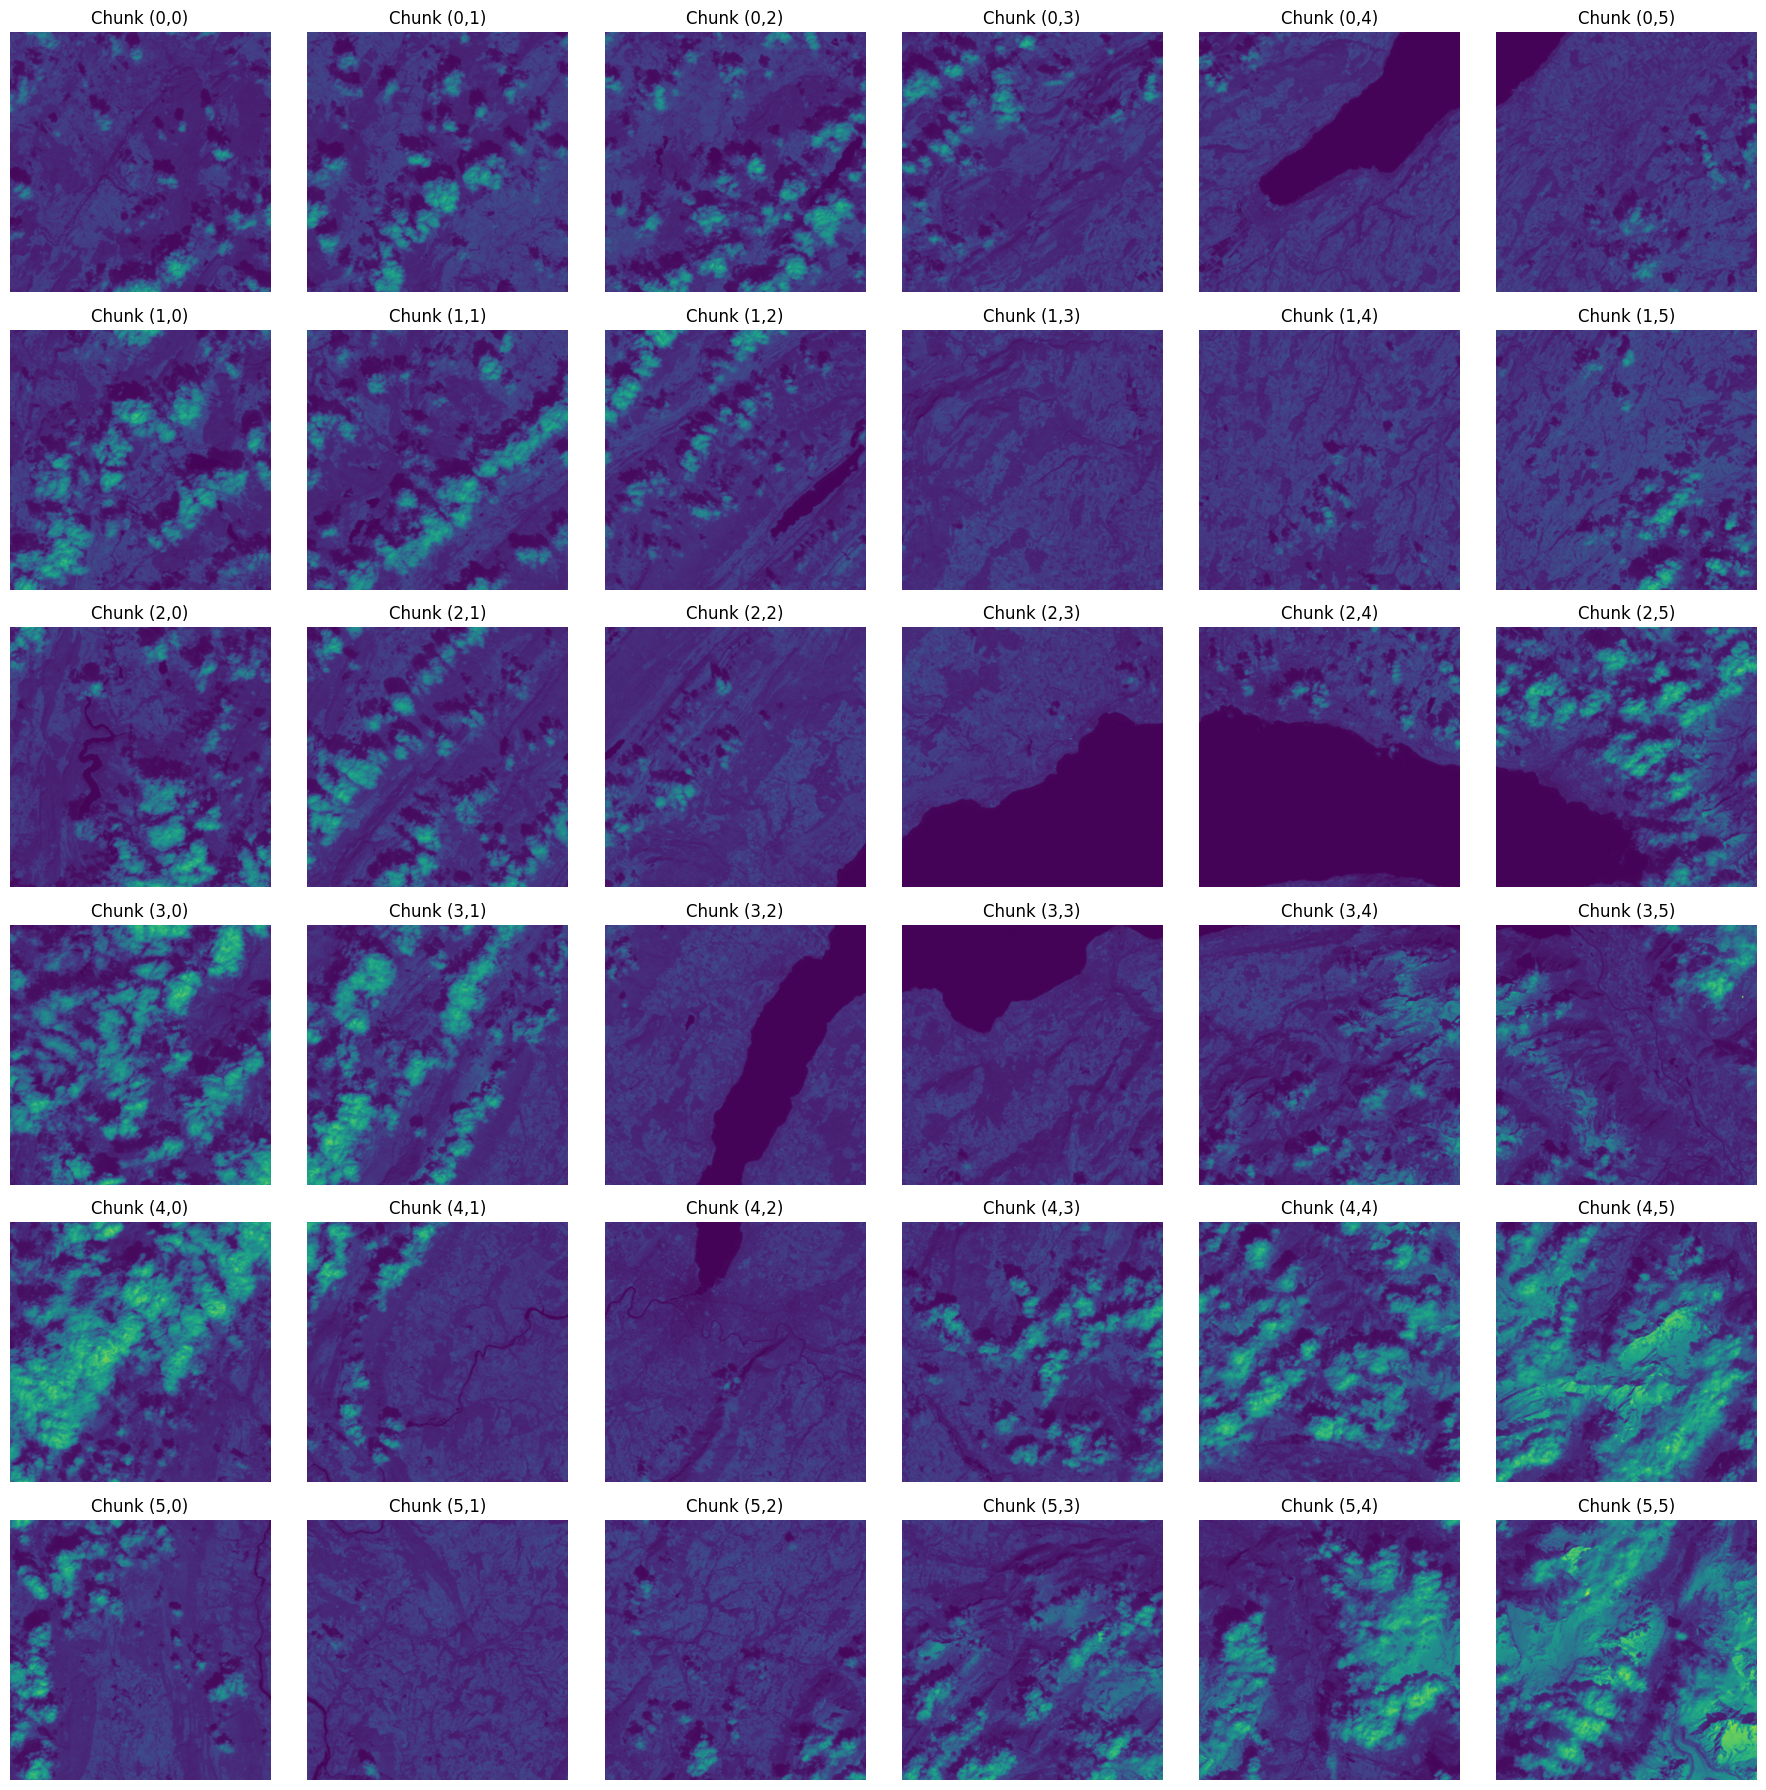

In [20]:
res = "60m"
band = "b09"

chunk_size_y, chunk_size_x, nb_chunks_y, nb_chunks_x = get_chunk_info(data_tree=dt, band=band, res=res)
plot_all_chunks(dt, band, res, chunk_size_y, chunk_size_x, nb_chunks_y, nb_chunks_x, cmap="viridis", verbose= True, figsize_scale=3)

Chunk size: y=1830, x=1830
Number of chunks: y=6, x=6
Chunk size [b02] --> [10m] = (1830, 1830) 

Chunk size: y=915, x=915
Number of chunks: y=6, x=6
Chunk size [b06] --> [20m] = (915, 915) 

Chunk size: y=305, x=305
Number of chunks: y=6, x=6
Chunk size [b09] --> [60m] = (305, 305) 



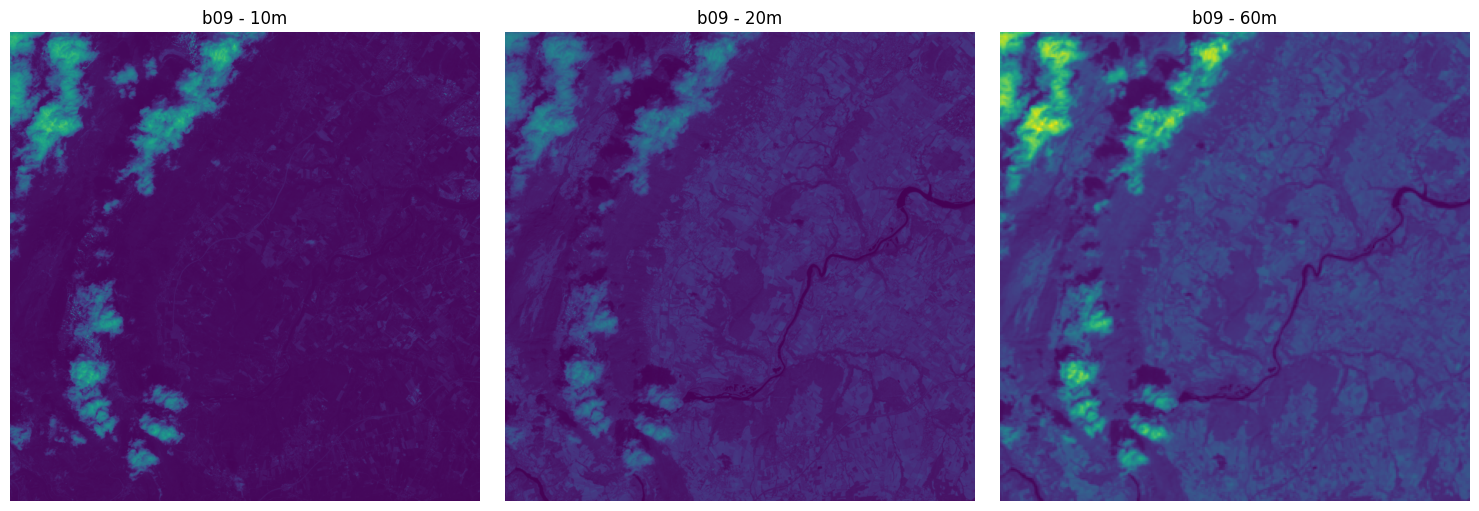

In [21]:
## Plot All the resolution for a given chunk
resolutions = ["10m", "20m", "60m"]
bands = ["b02","b06","b09"]
dt = xr.open_datatree(zarr_path[11], engine="zarr", mask_and_scale=False, chunks={})

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, res in enumerate(resolutions):

    # data = dt.measurements.reflectance[res_key]
    chunk_size_y, chunk_size_x, nb_chunks_y, nb_chunks_x = get_chunk_info(data_tree=dt, band=bands[i], res=res)
    chunk = get_chunk(data_tree=dt, res=res, chunk_size_y=chunk_size_y, chunk_size_x=chunk_size_x, chunk_y_idx=4, chunk_x_idx=1)
    chunk = chunk[bands[i]].load()
    print(f"Chunk size [{bands[i]}] --> [{res}] = {chunk.shape} \n")
    axes[i].imshow(chunk, cmap="viridis")
    axes[i].set_title(f"{band} - {res}")
    axes[i].axis("off")
plt.tight_layout()
plt.show()

## Conversion to DGGS 

In [22]:
def get_bands(data_tree, res):

    res_key = f"r{res}"
    bands = data_tree.measurements.reflectance[res_key]
    return list(bands.keys())

In [23]:
dt = xr.open_datatree(zarr_path[11], engine="zarr", mask_and_scale=False, chunks={})
res = "20m"
band_list = get_bands(data_tree=dt, res=res)
chunk_size_y, chunk_size_x, nb_chunks_y, nb_chunks_x = get_chunk_info(data_tree=dt, band=band_list[0], res=res)
chunk = get_chunk(data_tree=dt, res=res, chunk_size_y=chunk_size_y,chunk_size_x=chunk_size_x, chunk_y_idx=3, chunk_x_idx=2).load()

Chunk size: y=915, x=915
Number of chunks: y=6, x=6


In [24]:
import xarray as xr
import pandas as pd
import healpy as hp
from tqdm import tqdm
from pyproj import Transformer
import xdggs

### Coordinate transformation

In [25]:
ds = chunk.copy()
ds

<xarray.DataTree 'r20m'>
Group: /
    Dimensions:  (y_20m: 915, x_20m: 915)
    Coordinates:
        x        (x_20m) float32 4kB 7.366e+05 7.366e+05 ... 7.548e+05 7.548e+05
        y        (y_20m) float32 4kB 5.145e+06 5.145e+06 ... 5.127e+06 5.127e+06
    Dimensions without coordinates: y_20m, x_20m
    Data variables:
        b05      (y_20m, x_20m) float64 7MB 0.1124 0.0761 0.0795 ... 0.1001 0.0937
        b06      (y_20m, x_20m) float64 7MB 0.1228 0.1061 0.1126 ... 0.2909 0.2906
        b07      (y_20m, x_20m) float64 7MB 0.1289 0.1145 0.1231 ... 0.3823 0.3858
        b11      (y_20m, x_20m) float64 7MB 0.0896 0.0885 0.0877 ... 0.169 0.1654
        b12      (y_20m, x_20m) float64 7MB 0.053 0.0546 0.0493 ... 0.0843 0.0819
        b8a      (y_20m, x_20m) float64 7MB 0.1247 0.1207 0.1286 ... 0.4106 0.4135

In [26]:
# ds = dt.measurements.reflectance.r10m
x = ds['x'].values
y = ds['y'].values
xx, yy = np.meshgrid(x, y)
print(f"Coordinate grid shape: {xx.shape}")
print(f"X range: {x.min():.0f} to {x.max():.0f}")
print(f"Y range: {y.min():.0f} to {y.max():.0f}")

Coordinate grid shape: (915, 915)
X range: 736570 to 754850
Y range: 5126830 to 5145110


In [27]:
# Setup coordinate transformation from UTM to WGS84 lat/lon
utm_crs = dt.other_metadata['horizontal_CRS_code']
transformer = Transformer.from_crs(utm_crs, "EPSG:4326", always_xy=True)
lon, lat = transformer.transform(xx, yy)
# Convert UTM coordinates to latitude/longitude
lon, lat = transformer.transform(xx, yy)
level= 18
nside=2**(level)
idx=hp.ang2pix(nside,lon,lat,lonlat=True,nest=True)
lidx,ilidx=np.unique(idx,return_inverse=True)
imh=np.bincount(ilidx.flatten())
h_lon,h_lat=hp.pix2ang(nside,lidx.flatten(),lonlat=True,nest=True)

In [28]:
from numcodecs import Zstd

class proj_odysea:
    """
    HEALPix projection class for spatial data aggregation compatible with xdggs
    """

    def __init__(
        self,
        level,
        heal_idx,
        inv_idx,
        nscale=2,
        nest=False,
        chunk_size=4096,
        cell_id_name="cell_ids",
    ):
        self.level = level
        self.nside = 2**(level)
        self.nscale = nscale
        self.nest = nest
        self.chunk_size = chunk_size
        self.cell_id_name = cell_id_name

        # HEALPix cell setup with ONLY xdggs-compatible attributes
        self.cell_ids = heal_idx.flatten()
        self.var_cell_ids = xr.DataArray(
            self.cell_ids,
            dims="cells",
            attrs={
                "grid_name": "healpix",
                "indexing_scheme": "nested" if self.nest else "ring",
                "resolution": self.level,
                # Remove ALL legacy attributes that cause conflicts
            }
        )
        self.inv_idx = inv_idx.flatten()
        self.him = np.bincount(self.inv_idx)

    def eval(self, ds):
        """
        Convert dataset to HEALPix projection without time dimension
        """
        var_name = list(ds.data_vars)
        print(f"Processing {len(var_name)} variables: {var_name}")

        # Initialize 2D data array (bands, cells)
        all_data = np.zeros([len(var_name), self.cell_ids.shape[0]])

        # Process each variable
        for i in range(len(var_name)):
            ivar = var_name[i]
            print(f"Processing {ivar} ({i+1}/{len(var_name)})")

            # Flatten spatial data
            b_data = ds[ivar].values.flatten()

            # Find valid data (non-zero and non-NaN)
            idx = np.where((b_data != 0) & (~np.isnan(b_data)))

            # Aggregate to HEALPix cells
            data = np.bincount(
                self.inv_idx[idx],
                weights=b_data[idx],
                minlength=self.cell_ids.shape[0]
            )

            # Count pixels per cell
            hdata = np.bincount(
                self.inv_idx[idx],
                minlength=self.cell_ids.shape[0]
            )

            # Calculate mean (handle division by zero)
            data = data.astype(float)
            data[hdata == 0] = np.nan
            valid_mask = hdata > 0
            data[valid_mask] = data[valid_mask] / hdata[valid_mask]

            # Store in 2D array
            all_data[i] = data

        # Create DataArray with correct dimensions
        data_array = xr.DataArray(
            all_data,
            dims=("bands", "cells"),
            coords={
                "bands": var_name,
                self.cell_id_name: self.var_cell_ids
            },
            name='Sentinel2',
            attrs={
                "description": "Sentinel-2 reflectance aggregated to HEALPix cells"
            }
        )

        # Convert to Dataset
        ds_total = data_array.to_dataset()

        # Set ONLY xdggs-compatible attributes (no extra attributes)
        ds_total[self.cell_id_name].attrs = {
            "grid_name": "healpix",
            "indexing_scheme": "nested" if self.nest else "ring",
            "resolution": self.level,
        }

        # Apply chunking
        chunk_size_data = max(1, int((12 * (4**self.level)) / self.chunk_size))
        ds_total = ds_total.chunk({"cells": chunk_size_data})

        print(f"HEALPix conversion complete - Level {self.level}, {len(self.cell_ids):,} cells")

        return ds_total

In [29]:
from numcodecs import Zstd

nside=2**level
nside_list=2**level
nest=True
chunk_size = 4096 #12 *(2**level)
chunk_size_data = int(( 12 * (4**level)) / chunk_size)
print("chunk_size", chunk_size)
zstd_compressor = Zstd(level=3)
# Define a common compression setting
compression_settings = {"compressor": zstd_compressor,}

chunk_size 4096


In [30]:
pr=proj_odysea(level, lidx, ilidx, nest=nest, chunk_size= chunk_size, nscale=1)
ds_healpix =pr.eval(ds)
ds = ds_healpix.pipe(xdggs.decode)
cell_centers = ds.dggs.cell_centers()

Processing 6 variables: ['b05', 'b06', 'b07', 'b11', 'b12', 'b8a']
Processing b05 (1/6)
Processing b06 (2/6)
Processing b07 (3/6)
Processing b11 (4/6)
Processing b12 (5/6)
Processing b8a (6/6)
HEALPix conversion complete - Level 18, 540,155 cells


In [31]:
derived_ds = ds_healpix.assign_coords(
    cell_centers.rename_vars({"latitude": "lat", "longitude": "lon"}).coords
)
derived_ds

<xarray.Dataset> Size: 39MB
Dimensions:    (bands: 6, cells: 540155)
Coordinates:
  * bands      (bands) <U3 72B 'b05' 'b06' 'b07' 'b11' 'b12' 'b8a'
    cell_ids   (cells) int64 4MB dask.array<chunksize=(540155,), meta=np.ndarray>
    lat        (cells) float64 4MB 46.25 46.25 46.25 46.25 ... 46.42 46.42 46.42
    lon        (cells) float64 4MB 6.216 6.216 6.216 6.215 ... 6.103 6.103 6.103
Dimensions without coordinates: cells
Data variables:
    Sentinel2  (bands, cells) float64 26MB dask.array<chunksize=(6, 540155), meta=np.ndarray>

In [32]:
def create_arrow_table(polygons, arr, coords=None):
    from arro3.core import Array, ChunkedArray, Schema, Table

    if coords is None:
        coords = ["latitude", "longitude"]

    array = Array.from_arrow(polygons)
    name = arr.name or "data"
    arrow_arrays = {
        "geometry": array,
        "cell_ids": ChunkedArray([Array.from_numpy(arr.coords["cell_ids"])]),
        name: ChunkedArray([Array.from_numpy(arr.data)]),
    } | {
        coord: ChunkedArray([Array.from_numpy(arr.coords[coord].data)])
        for coord in coords
        if coord in arr.coords
    }

    fields = [array.field.with_name(name) for name, array in arrow_arrays.items()]
    schema = Schema(fields)

    return Table.from_arrays(list(arrow_arrays.values()), schema=schema)

def normalize(var, center=None):
    from matplotlib.colors import CenteredNorm, Normalize

    if center is None:
        vmin = var.min(skipna=True)
        vmax = var.max(skipna=True)
        normalizer = Normalize(vmin=vmin, vmax=vmax)
    else:
        halfrange = np.abs(var - center).max(skipna=True)
        normalizer = CenteredNorm(vcenter=center, halfrange=halfrange)

    return normalizer(var.data)

def exploire_layer(
    arr,
    cell_dim="cells",
    cmap="viridis",
    center=None,
    alpha=None,
):
    from lonboard import SolidPolygonLayer
    from lonboard.colormap import apply_continuous_cmap
    from matplotlib import colormaps

    if len(arr.dims) != 1 or cell_dim not in arr.dims:
        raise ValueError(
            f"exploration only works with a single dimension ('{cell_dim}')"
        )

    cell_ids = arr.dggs.coord.data
    grid_info = arr.dggs.grid_info

    polygons = grid_info.cell_boundaries(cell_ids, backend="geoarrow")

    # normalized_data = normalize(arr.variable, center=center)

    colormap = colormaps[cmap]
    colors = apply_continuous_cmap(arr.variable, colormap, alpha=alpha)

    table = create_arrow_table(polygons, arr)
    layer = SolidPolygonLayer(table=table, filled=True, get_fill_color=colors)

    return layer

In [33]:
import lonboard

# Use of tanh to concentrate the scale variation for the lower values
ds1=ds.Sentinel2.sel(bands=band_list[-1]).compute()

lonboard.Map(
    [
        exploire_layer(
            ds1,
            alpha=0.80,
            cmap='viridis'
        )
    ]
)

Map(custom_attribution='', layers=(SolidPolygonLayer(filled=True, get_fill_color=arro3.core.ChunkedArray<Fixed…

In [34]:
def healpix_projection(dt, res="10m", chunk=True, level=16, chunk_size=4096):
    import numpy as np
    import healpy as hp
    from pyproj import Transformer

    # 1. Extract data and grid
    if chunk==True:

        band_list = get_bands(data_tree=dt, res=res)
        chunk_size_y, chunk_size_x, nb_chunks_y, nb_chunks_x = get_chunk_info(data_tree=dt, band=band_list[0], res=res)
        ds = get_chunk(data_tree=dt, res=res, chunk_size_y=chunk_size_y,chunk_size_x=chunk_size_x, chunk_y_idx=3, chunk_x_idx=2).load()


    else:
        ds = dt.measurements.reflectance[f"r{res}"]

    x = ds["x"].values
    y = ds["y"].values
    xx, yy = np.meshgrid(x, y)

    print(f"Coordinate grid shape: {xx.shape}")
    print(f"X range: {x.min():.0f} to {x.max():.0f}")
    print(f"Y range: {y.min():.0f} to {y.max():.0f}")

    # 2. Transform UTM to lat/lon
    utm_crs = dt.other_metadata["horizontal_CRS_code"]
    transformer = Transformer.from_crs(utm_crs, "EPSG:4326", always_xy=True)
    lon, lat = transformer.transform(xx, yy)

    # 3. Generate HEALPix indices
    nside = 2 ** level
    idx = hp.ang2pix(nside, lon, lat, lonlat=True, nest=True)
    lidx, ilidx = np.unique(idx, return_inverse=True)

    print(f"HEALPix Level {level} → {len(lidx):,} unique cells")

    # 4. Project to HEALPix using your custom class
    proj = proj_odysea(level, lidx, ilidx, nest=True, chunk_size=chunk_size)
    ds_healpix = proj.eval(ds.to_dataset())

    # # 5. Decode to add lat/lon if available via xdggs
    # if "xdggs" in globals():
    ds_healpix = ds_healpix.pipe(xdggs.decode)

    return ds_healpix

In [35]:
ds_healpix = healpix_projection(dt=dt, res="20m",chunk=True, level=18, chunk_size=4096)

Chunk size: y=915, x=915
Number of chunks: y=6, x=6
Coordinate grid shape: (915, 915)
X range: 736570 to 754850
Y range: 5126830 to 5145110
HEALPix Level 18 → 540,155 unique cells
Processing 6 variables: ['b05', 'b06', 'b07', 'b11', 'b12', 'b8a']
Processing b05 (1/6)
Processing b06 (2/6)
Processing b07 (3/6)
Processing b11 (4/6)
Processing b12 (5/6)
Processing b8a (6/6)
HEALPix conversion complete - Level 18, 540,155 cells


In [36]:
ds_healpix

<xarray.Dataset> Size: 30MB
Dimensions:    (bands: 6, cells: 540155)
Coordinates:
  * bands      (bands) <U3 72B 'b05' 'b06' 'b07' 'b11' 'b12' 'b8a'
  * cell_ids   (cells) int64 4MB dask.array<chunksize=(540155,), meta=np.ndarray>
Dimensions without coordinates: cells
Data variables:
    Sentinel2  (bands, cells) float64 26MB dask.array<chunksize=(6, 540155), meta=np.ndarray>
Indexes:
    cell_ids  HealpixIndex(level=18, indexing_scheme=nested)

In [37]:
lonboard.Map(
    [
        exploire_layer(
            ds_healpix.Sentinel2.sel(bands=band_list[-1]).compute().compute(),
            alpha=0.80,
            cmap='viridis'
        )
    ]
)

Map(custom_attribution='', layers=(SolidPolygonLayer(filled=True, get_fill_color=arro3.core.ChunkedArray<Fixed…

- HEALPix is not arranged on a 2D grid like a regular raster.
- it's a spherical hierarchical tiling. The cell IDs don't map directly to a 2D grid
- but we can arrange local neighborhoods of a central pixel into a 2D patch.

To build a 224 × 224 array suitable for a CNN:

🔹 Step 1: Choose a center cell_id
E.g., the one at ds_healpix.cell_ids.values[index].

🔹 Step 2: Use healpy.query_disc or healpy.vec2ang to collect neighbors within a radius
But 224 × 224 = 50,176 pixels is a lot — even at level 16, your full map has only ~1.2 million pixels.

🔹 Step 3: Convert neighbors into a 2D grid
HEALPix cells can be flattened into a neighborhood but don't naturally form a square.

We must project the neighbors onto a 2D tangent plane (local flat grid).

Then interpolate or reshape into 224 × 224.


In [77]:
ds_healpix.cell_ids[40].values

array(46370881505)

In [ ]:
import healpy as hp

def get_closest_neighbor(cell_id, level):
    nside = 2 ** level
    neighbors = hp.get_all_neighbours(nside, cell_id, nest=True)
    return neighbors

level = 19
cell_id = 46370881505

neighbors = get_closest_neighbor(cell_id, level)
print(f"Cell {cell_id} has {len(neighbors)} neighbors: {neighbors}")

Cell 46370881505 has 8 neighbors: [46370881504 46370881506 46370881507 46370881510 46370881508 46370881486
 46370881483 46370881482]


In [79]:
selected_ds_healpix = ds_healpix.sel(cell_ids=list(neighbors))
selected_ds_healpix

<xarray.Dataset> Size: 520B
Dimensions:    (bands: 6, cells: 8)
Coordinates:
  * bands      (bands) <U3 72B 'b05' 'b06' 'b07' 'b11' 'b12' 'b8a'
  * cell_ids   (cells) int64 64B dask.array<chunksize=(8,), meta=np.ndarray>
Dimensions without coordinates: cells
Data variables:
    Sentinel2  (bands, cells) float64 384B dask.array<chunksize=(6, 8), meta=np.ndarray>
Indexes:
    cell_ids  HealpixIndex(level=18, indexing_scheme=nested)

In [80]:
nh_healpix = selected_ds_healpix.Sentinel2.sel(bands=band_list[-1]).compute()
nh_healpix

<xarray.DataArray 'Sentinel2' (cells: 8)> Size: 64B
array([0.428  , 0.4457 , 0.4551 , 0.4631 , 0.44655, 0.4503 , 0.4595 ,
       0.4397 ])
Coordinates:
    bands     <U3 12B 'b8a'
  * cell_ids  (cells) int64 64B 46370881504 46370881506 ... 46370881482
Dimensions without coordinates: cells
Indexes:
    cell_ids  HealpixIndex(level=18, indexing_scheme=nested)
Attributes:
    description:  Sentinel-2 reflectance aggregated to HEALPix cells

In [88]:
import healpy as hp
import numpy as np

def get_neighbors_in_radius(cell_id, level, radius_meters):

    # use small angle approximation
    # tan(alpha) = radius_meters / earth_radius_m
    # for small angle ~ 0 alpha = radius_meters / earth_radius_m

    earth_radius_m = 6374581.4671  # Mean Earth radius in meters
    radius_rad = radius_meters / earth_radius_m

    nside = 2 ** level
    vec = hp.pix2vec(nside, cell_id, nest=True)
    # Inclusive
    # If False, return the exact set of pixels whose pixel centers lie within the disk
    neighbors = hp.query_disc(nside, vec, radius_rad, inclusive=False, nest=True)
    return neighbors

# Example usage
level = 18
cell_id = 46370881505  # center pixel
radius_meters = 60
neighbors = get_neighbors_in_radius(cell_id, level, radius_meters)

print(f"Found {len(neighbors)} pixels within {radius_meters}m of cell {cell_id}")

Found 19 pixels within 60m of cell 46370881505


In [89]:
selected_ds_healpix = ds_healpix.sel(cell_ids=list(neighbors))
selected_ds_healpix

KeyError: "not all values found in index 'cell_ids'"

In [87]:
import lonboard

lonboard.Map(
    [
        exploire_layer(
            selected_ds_healpix.Sentinel2.sel(bands=band_list[-1]).compute(),
            alpha=0.80,
            cmap='viridis'
        )
    ]
)

Map(custom_attribution='', layers=(SolidPolygonLayer(filled=True, get_fill_color=arro3.core.ChunkedArray<Fixed…

In [62]:
data = selected_ds_healpix.Sentinel2.compute()
data

<xarray.DataArray 'Sentinel2' (bands: 6, cells: 9)> Size: 432B
array([[0.0289 , 0.0288 , 0.0287 , 0.0289 , 0.0289 , 0.0289 , 0.0289 ,
        0.0289 , 0.0288 ],
       [0.0277 , 0.0277 , 0.0277 , 0.028  , 0.02785, 0.0278 , 0.0279 ,
        0.0284 , 0.0278 ],
       [0.0266 , 0.0273 , 0.027  , 0.0272 , 0.0268 , 0.0273 , 0.0272 ,
        0.0266 , 0.0268 ],
       [0.0068 , 0.0067 , 0.0067 , 0.0067 , 0.00665, 0.00665, 0.0067 ,
        0.0068 , 0.0067 ],
       [0.0046 , 0.0045 , 0.0045 , 0.0046 , 0.00425, 0.00425, 0.0044 ,
        0.0048 , 0.00415],
       [0.0227 , 0.0227 , 0.02265, 0.0227 , 0.02235, 0.0222 , 0.0225 ,
        0.0229 , 0.0221 ]])
Coordinates:
  * bands     (bands) <U3 72B 'b05' 'b06' 'b07' 'b11' 'b12' 'b8a'
  * cell_ids  (cells) int64 72B 46370901990 46370901991 ... 46370902010
Dimensions without coordinates: cells
Indexes:
    cell_ids  HealpixIndex(level=18, indexing_scheme=nested)
Attributes:
    description:  Sentinel-2 reflectance aggregated to HEALPix cells

In [63]:
data

<xarray.DataArray 'Sentinel2' (bands: 6, cells: 9)> Size: 432B
array([[0.0289 , 0.0288 , 0.0287 , 0.0289 , 0.0289 , 0.0289 , 0.0289 ,
        0.0289 , 0.0288 ],
       [0.0277 , 0.0277 , 0.0277 , 0.028  , 0.02785, 0.0278 , 0.0279 ,
        0.0284 , 0.0278 ],
       [0.0266 , 0.0273 , 0.027  , 0.0272 , 0.0268 , 0.0273 , 0.0272 ,
        0.0266 , 0.0268 ],
       [0.0068 , 0.0067 , 0.0067 , 0.0067 , 0.00665, 0.00665, 0.0067 ,
        0.0068 , 0.0067 ],
       [0.0046 , 0.0045 , 0.0045 , 0.0046 , 0.00425, 0.00425, 0.0044 ,
        0.0048 , 0.00415],
       [0.0227 , 0.0227 , 0.02265, 0.0227 , 0.02235, 0.0222 , 0.0225 ,
        0.0229 , 0.0221 ]])
Coordinates:
  * bands     (bands) <U3 72B 'b05' 'b06' 'b07' 'b11' 'b12' 'b8a'
  * cell_ids  (cells) int64 72B 46370901990 46370901991 ... 46370902010
Dimensions without coordinates: cells
Indexes:
    cell_ids  HealpixIndex(level=18, indexing_scheme=nested)
Attributes:
    description:  Sentinel-2 reflectance aggregated to HEALPix cells

In [64]:
import torch
from torch.nn import functional as F
import torch
from torch import nn

x = data.values
print(x.shape)
x_tensor = torch.from_numpy(x.astype(np.float32))
# Add batch dimension => shape: (1, channels, sequence_length)
x_tensor = x_tensor.unsqueeze(0)
print(x_tensor.shape)
in_channels = x_tensor.shape[0]
out_channels = 16
kernel_size = 3
stride = 2

(6, 9)
torch.Size([1, 6, 9])


In [ ]:
# Simple 1D convolution block
def simple_conv(in_channels, out_channels, kernel_size, stride):
    return nn.Sequential(
        nn.Conv1d(in_channels, out_channels, kernel_size, stride),
        nn.ReLU()
    )

    # padding = (kernel_size - 1) // 2
    # return nn.Sequential(
    #     nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding=padding),
    #     nn.ReLU()
    # )

# Define Model
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = simple_conv(in_channels=4, out_channels=128, kernel_size=9, stride=9)

    def forward(self, x):
        return self.conv1(x)

In [ ]:
# Instantiate and apply model
model = Model()
output = model(x_tensor)
print(f"Input shape: {x_tensor.shape}")
print(f"Output shape: {output.shape}")

In [ ]:
x_tensor.shape

In [ ]:
# Get NumPy output from model
output_np = output.detach().numpy()[0]  # shape: (C_out, N_cells)
output_np.shape